<div align="center">

# Бэггинг: создание ансамбля классификаторов из исходного набора данных

</div>

---

**Бэггинг (bagging, bootstrap aggregating)** - метод обучения ансамбля, тесно связанный с классификатором **VotingClassifier** из библиотеки scikit-learn, который реализует **мажоритарное голосование** (majority voting) по предсказаниям нескольких моделей.

## Бэггинг (Bagging, bootstrap aggregating)

### Что это?

* Метод ансамблирования, который использует **бутстрэп-выборки** — случайные выборки с повторениями из исходного обучающего набора.
* В отличие от простого ансамбля, где все классификаторы обучаются на одном и том же полном наборе данных, здесь каждый классификатор обучается на своей уникальной бутстрэп-выборке.

### Как это работает?

1. Из исходного набора данных создаются $t$ бутстрэп-выборок — случайных подмножеств с заменой.

   * В каждой подвыборке есть повторы одних объектов, а некоторые объекты из исходного набора могут не попасть вовсе.
2. На каждой из этих выборок обучается отдельный классификатор (обычно необрезанное дерево решений).
3. Итоговое решение ансамбля получается путём **мажоритарного голосования** предсказаний всех классификаторов.

### Связь со случайным лесом

* **Случайный лес** — это частный случай бэггинга.
* В случайном лесе дополнительно при обучении каждого дерева выбирается случайное подмножество признаков (фич).
* Это добавляет ещё больше случайности и снижает корреляцию между деревьями, повышая качество ансамбля.


### Зачем бэггинг нужен?

* Уменьшает дисперсию модели (устраняет переобучение).
* Повышает устойчивость и точность за счёт объединения разнородных обученных моделей.

In [29]:
# Применение bagging на наборе данных Wine
# Рассмотрим только классы вин 2 и 3, и выберем два признака:
# OD280/OD315 of diluted wines и Alcohol

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [30]:
# Загрузка данных
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/'
                      'wine/wine.data',
                      header = None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
# Отбрасываем класс 1
df_wine = df_wine[df_wine['Class label'] != 1]

# Разделение данных
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
y = df_wine['Class label'].values

df_wine[['Class label', 'Alcohol', 'OD280/OD315 of diluted wines']].head()

,Class label,Alcohol,OD280/OD315 of diluted wines
59,2,12.37,1.82
60,2,12.33,1.67
61,2,12.64,1.59
62,2,13.67,2.46
63,2,12.37,2.87


In [31]:
# Кодирование меток класса в двоичный формат
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size = 0.2,
                     random_state = 1,
                     stratify = y)

In [32]:
# Применим в качестве базового классификатора 
# несокращенное дерево решений и создадим ансамбль из 
# 500 деревьев обученных на разных бустреп-выборках

tree = DecisionTreeClassifier(criterion = 'entropy',
                              random_state = 1,
                              max_depth = None)

bag = BaggingClassifier(estimator = tree,
                        n_estimators = 500,
                        max_samples = 1.0,
                        max_features = 1.0,
                        bootstrap = True,
                        bootstrap_features = False,
                        n_jobs = 1,
                        random_state = 1)


In [33]:
# Рассчитаем точность на train и test, чтобы сравнить 
# производительность классификатора беггинга с 
# производительностью одного несокращенного дерева решений

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Точность при обучении/тестировании '
      f'{tree_train:.3f}/{tree_test:.3f}')

Точность при обучении и тестировании 1.000/0.833


Судя по точности, несокращенное дерево решений правильно предсказыает все метки обучающего класса, но дает более низкую точность на тестовом наборе, что указывает на переобучение модели (высокую дисперсию).

In [35]:
# Bagging

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Точность бэггинга при обучении/тестировании '
      f'{bag_train:.3f}/{bag_test:.3f}')

Точность бэггинга при обучении/тестировании 1.000/0.917


Как видно, бэггинг-классификатор имеет более высокую точность на тестовой выборке, теперь можно сравнить области принятий решений.

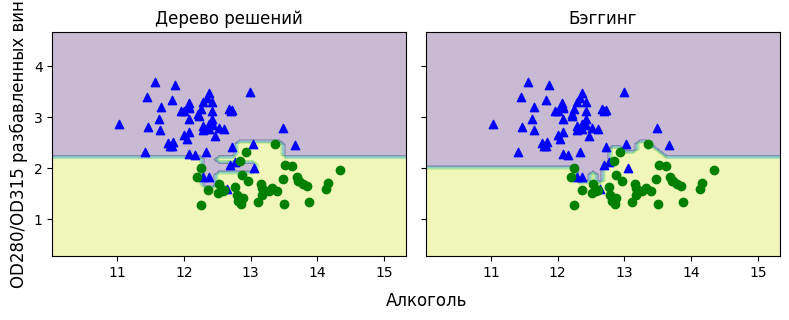

In [38]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows = 1, ncols = 2,
                        sharex = 'col',
                        sharey = 'row',
                        figsize = (8, 3))

for idx, clf, tt in zip ([0, 1], [tree, bag],
                         ['Дерево решений', 'Бэггинг']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c = 'blue', marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c = 'green', marker = 'o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('OD280/OD315 разбавленных вин', fontsize = 12)
plt.tight_layout()
plt.text(0, -0.2,
         s = 'Алкоголь',
         ha = 'center',
         va = 'center',
         fontsize = 12,
         transform = axarr[1].transAxes)
plt.show()

На графике видно, что кусочно-линейная разделяющая граница трехузлового дерева решений выглядит более гладкой в случае использования бэггинга.

---

## Когда бэггинг проявляет себя лучше всего

* **Сложные задачи** классификации + **высокая размерность** данных → отдельные деревья решений легко переобучаются.
* Бэггинг снижает **дисперсию** (variance) модели — сглаживает разброс предсказаний за счёт усреднения по ансамблю.

## Ограничения бэггинга

* Почти **не уменьшает смещение** (bias) — то есть систематическую ошибку модели.
* Если базовая модель слишком простая и не способна уловить закономерности в данных (высокий bias), бэггинг не спасёт.
* Поэтому в бэггинге используют **модели с низким bias**, но высокой variance, которые склонны к переобучению.
  **Пример:** несокращённые деревья решений.

📌 **Вывод:**
Бэггинг = хороший выбор для "шумных", сложных задач, когда модель имеет высокий разброс предсказаний, но способна хорошо подстраиваться под данные.